In [9]:
#! pip install ultralytics 
#! pip install psycopg2
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
import psycopg2
import im_utils
import db_ops
import pandas as pd

#### Get the full list of OLM images

In [50]:
query = f'''
SELECT DISTINCT ON (i.image_id)
	 i.s3_uri AS uri
	, i.image_id as image_id
	, b.brand_id as brand_id 
	, ci.cat_id as cat_id
FROM image AS i 
	LEFT JOIN brand_image AS bi
		ON i.image_id = bi.image_id
	LEFT JOIN brand as b
		ON b.brand_id = bi.brand_id 
	LEFT JOIN category_image as ci
		ON i.image_id = ci.image_id
ORDER BY i.image_id	;
'''
image_uri = db_ops.select_to_pandas(query, True, True)

/home/ubuntu/workspace/litter-imagery-brand-recognition/db_ops.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [56]:
image_uri['brand_id'] = image_uri['brand_id'].fillna(value = 111).astype(int)
image_uri['cat_id'] = image_uri['cat_id'].fillna(value = 20).astype(int)
image_uri.head()

,uri,image_id,brand_id,cat_id
0,s3://olm-pics-s3/112/Pftq4550WzgZA5euhgIEsLHGs...,1,111,47
1,s3://olm-pics-s3/112/HKXafwXvrpBQjoWC9aPtSY8lT...,2,111,39
2,s3://olm-pics-s3/112/69M58FGWNVp1ZTObF0YmkMfGN...,3,111,122
3,s3://olm-pics-s3/112/Da9HiIUxqaxY7WeKi2INrzgTG...,4,111,71
4,s3://olm-pics-s3/112/pUY1im8pNbPUAceAv17T5SCvm...,5,111,167


#### Load the label/no-label classifier model

In [4]:
model = YOLO('/home/ubuntu/box_model/best.pt')

#### Copy the image from the original S3, resize it, save to the procesed S3

In [58]:
for i in range(100):
    original_im_uri = image_uri['uri'].iloc[i]
    image_id = image_uri['image_id'].iloc[i]
    brand_id = image_uri['brand_id'].iloc[i]
    cat_id = image_uri['cat_id'].iloc[i]
    tmp_im_folder = '/home/ubuntu/temp-images'
    im_file = original_im_uri.split('/')[-1]
    scaled_im_uri = original_im_uri.replace('-pics-s3', '-processed-s3/scaled')
    scaled_im_local_path = os.path.join(tmp_im_folder, 'scaled', im_file)
    boxes_s3_path = scaled_im_uri.replace(im_file,'').replace('/scaled', '/boxes')
    
    os.system(f"aws s3 cp {original_im_uri} {tmp_im_folder}")  
    image_original = cv2.imread(tmp_im_folder+'/'+im_file)
    image_scaled = im_utils.ScaleImage(image_original, width = 640)
    cv2.imwrite(scaled_im_path + '/' + im_file, image_scaled)
    os.system(f"aws s3 cp {scaled_im_local_path} {scaled_im_uri}") 

    # Run the model inference on the test images
    results = model(scaled_im_path + '/' + im_file, conf = 0.2)

    # Set up the dataframe fo the boxes
    print('-'*30)
    print(im_file)
    boxes_df = pd.DataFrame(columns = ['image_id', 'brand_id', 'cat_id', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_pic_uri'])
    for result in results: # Iterate over each picture 
        # Find the saceling factor
        w_ratio = image_original.shape[1]/image_scaled.shape[1]
        h_ratio = image_original.shape[0]/image_scaled.shape[0]
        for prediction in result.boxes.xyxy:   # Iterate over each box
            # Get the coordinates of the box on the original image
            xmin, ymin, xmax, ymax = map(int, prediction) 
            xmin = int(xmin * w_ratio)
            xmax = int(xmax * w_ratio)
            ymin = int(ymin * h_ratio)
            ymax = int(ymax * h_ratio)
            postfix = f"-{xmin}-{ymin}-{xmax}-{ymax}"
            box_file = im_file.split('.')[0]+postfix+'.jpg' 
            #print(box_file)
            # Get the section of the original image that is in the box
            box_im = image_original[ymin:ymax, xmin:xmax,:]
            # Save the box as an individual file
            cv2.imwrite(scaled_im_path + '/' + box_file, box_im)
            idx = len(boxes_df)
            boxes_df.loc[idx, 'brand_id'] = brand_id
            boxes_df.loc[idx, 'cat_id'] = cat_id
            boxes_df.loc[idx, 'xmin_coord'] = xmin
            boxes_df.loc[idx, 'ymin_coord'] = ymin
            boxes_df.loc[idx, 'xmax_coord'] = xmax
            boxes_df.loc[idx, 'ymax_coord'] = ymax
            boxes_df.loc[idx, 'image_id']= image_id
            boxes_df.loc[idx, 'box_pic_uri']= boxes_s3_path + box_file
            os.system(f"aws s3 cp {scaled_im_path + '/' + box_file} {boxes_s3_path}") 
        # Create a plot
        #plt.figure(figsize=(10, 10))
        #plt.imshow(box_im)
        #plt.axis('off') # Hide the axis
        #plt.show()
    query = f'''
    DELETE FROM box
    WHERE image_id = {image_id}
    '''
    db_ops.run_single_query(query)
    db_ops.add_df(boxes_df, "box")

download: s3://olm-pics-s3/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg to ../../temp-images/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg
upload: ../../temp-images/scaled/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg to s3://olm-processed-s3/scaled/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg

image 1/1 /home/ubuntu/temp-images/scaled/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg: 480x640 1 logo, 34.5ms
Speed: 1.3ms preprocess, 34.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
------------------------------
Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg
upload: ../../temp-images/scaled/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg to s3://olm-processed-s3/boxes/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg
INSERT INTO box (image_id,brand_id,cat_id,xmin_coord,ymin_coord,xmax_coord,ymax_coord,box_pic_uri) VALUES ('1','111','47','792','1112','932','1416','s3://olm-processed-s3/boxes/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAq

#### Find bounding boxes for potential labels

HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg
upload: ../../temp-images/scaled/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg to s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg
HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-1221-774-1296-903.jpg
upload: ../../temp-images/scaled/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-1221-774-1296-903.jpg to s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-1221-774-1296-903.jpg
HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-936-678-1224-900.jpg
upload: ../../temp-images/scaled/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-936-678-1224-900.jpg to s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-936-678-1224-900.jpg


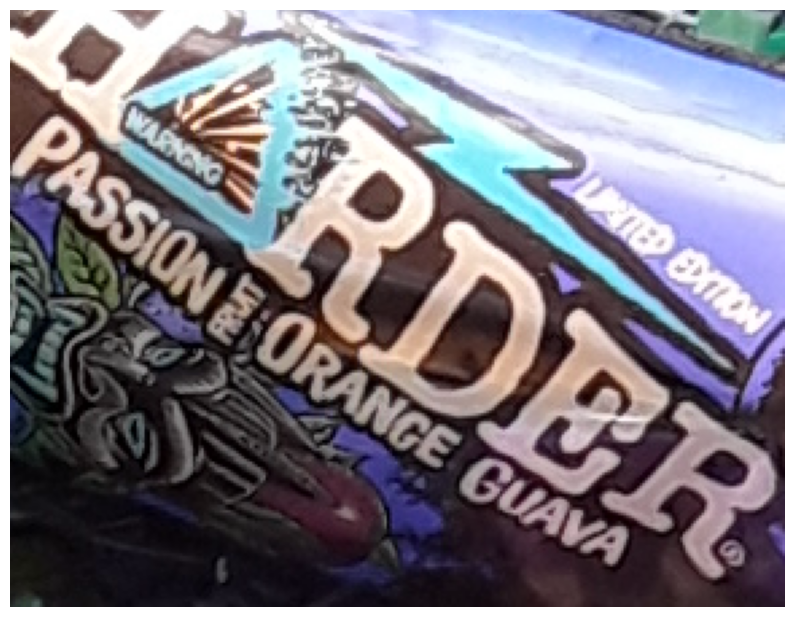

INSERT INTO box (image_id,brand_id,cat_id,xmin_coord,ymin_coord,xmax_coord,ymax_coord,box_pic_uri) VALUES ('2','111','20','612','1671','858','1884','s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg');
INSERT INTO box (image_id,brand_id,cat_id,xmin_coord,ymin_coord,xmax_coord,ymax_coord,box_pic_uri) VALUES ('2','111','20','1221','774','1296','903','s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-1221-774-1296-903.jpg');
INSERT INTO box (image_id,brand_id,cat_id,xmin_coord,ymin_coord,xmax_coord,ymax_coord,box_pic_uri) VALUES ('2','111','20','936','678','1224','900','s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-936-678-1224-900.jpg');


In [47]:
# Run the model inference on the test images
results = model(scaled_im_path + '/' + im_file, conf = 0.2)
boxes_df = pd.DataFrame(columns = ['image_id', 'brand_id', 'cat_id', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_pic_uri'])
for result in results: # Iterate over each picture 
    # Find the saceling factor
    w_ratio = image_original.shape[1]/image_scaled.shape[1]
    h_ratio = image_original.shape[0]/image_scaled.shape[0]
    for prediction in result.boxes.xyxy:   # Iterate over each box
        # Get the coordinates of the box on the original image
        xmin, ymin, xmax, ymax = map(int, prediction) 
        xmin = int(xmin * w_ratio)
        xmax = int(xmax * w_ratio)
        ymin = int(ymin * h_ratio)
        ymax = int(ymax * h_ratio)
        postfix = f"-{xmin}-{ymin}-{xmax}-{ymax}"
        box_file = im_file.split('.')[0]+postfix+'.jpg' 
        #print(box_file)
        # Get the section of the original image that is in the box
        box_im = image_original[ymin:ymax, xmin:xmax,:]
        # Save the box as an individual file
        cv2.imwrite(scaled_im_path + '/' + box_file, box_im)
        idx = len(boxes_df)
        boxes_df.loc[idx, 'brand_id'] = 111
        boxes_df.loc[idx, 'cat_id'] = 20
        boxes_df.loc[idx, 'xmin_coord'] = xmin
        boxes_df.loc[idx, 'ymin_coord'] = ymin
        boxes_df.loc[idx, 'xmax_coord'] = xmax
        boxes_df.loc[idx, 'ymax_coord'] = ymax
        boxes_df.loc[idx, 'image_id']= image_id
        boxes_df.loc[idx, 'box_pic_uri']= boxes_s3_path + box_file
        os.system(f"aws s3 cp {scaled_im_path + '/' + box_file} {boxes_s3_path}") 
    # Create a plot
    #plt.figure(figsize=(10, 10))
    #plt.imshow(box_im)
    #plt.axis('off') # Hide the axis
    #plt.show()
query = f'''
DELETE FROM box
WHERE image_id = {image_id}
'''
db_ops.run_single_query(query)
db_ops.add_df(boxes_df, "box")

In [48]:
boxes_df 

,image_id,brand_id,cat_id,xmin_coord,ymin_coord,xmax_coord,ymax_coord,box_pic_uri
0,2,111,20,612,1671,858,1884,s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjo...
1,2,111,20,1221,774,1296,903,s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjo...
2,2,111,20,936,678,1224,900,s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjo...


INSERT INTO box (image_id,brand_id,cat_id,xmin_coord,ymin_coord,xmax_coord,ymax_coord,box_pic_uri) VALUES ('1','111','20','792','1112','932','1416','s3://olm-processed-s3/boxes/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg');
